In this notebook, we will build a 3D map of a scene from a small set of images and refine it with the featuremetric optimization. We then localize an image downloaded from the Internet and show the effect of the refinement.

# Setup
We start by defining some output paths: where the intermediate files will be stored.

In [3]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
import os
import time
import sys
from hloc import extract_features, match_features, reconstruction, pairs_from_exhaustive, visualization
from hloc.visualization import plot_images, read_image
from hloc.utils.viz_3d import init_figure, plot_points, plot_reconstruction, plot_camera_colmap
from pixsfm.util.visualize import init_image, plot_points2D
from pixsfm.refine_hloc import PixSfM
from pixsfm import ostream_redirect
from PIL import Image, ImageDraw
import pycolmap
from pathlib import Path
import numpy as np
#import visualize_model
# redirect the C++ outputs to notebook cells
cpp_out = ostream_redirect(stderr=True, stdout=True)
cpp_out.__enter__()

In [4]:
import torch 
print(torch.__version__)
print(torch.cuda.get_arch_list())

1.9.1+cu111
['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']


In [5]:
colors = {
    "red": np.array([255, 0, 0]),
    "green": np.array([0, 255, 0]),
    "blue": np.array([0, 0, 255]),
    "yellow": np.array([255, 255, 0]),
    "cyan": np.array([0, 255, 255]),
    "magenta": np.array([255, 0, 255]),
    "white": np.array([255, 255, 255]),
    "black": np.array([0, 0, 0]),
    "orange": np.array([255, 165, 0]),
    "purple": np.array([128, 0, 128]),
    "brown": np.array([165, 42, 42]),
    "gray": np.array([128, 128, 128]),
    "pink": np.array([255, 192, 203]),
    "lime": np.array([0, 255, 0]),
    "indigo": np.array([75, 0, 130])
}

#### SVO Pointcloud visualization

In [8]:
from plyfile import PlyData
svo_data = PlyData.read('/home/skumar/benchmark_pixSFM/ply/svo_pink.ply')
v1 = svo_data['vertex'].data
p1 = np.vstack([v1['x'], v1['y'], v1['z']]).T

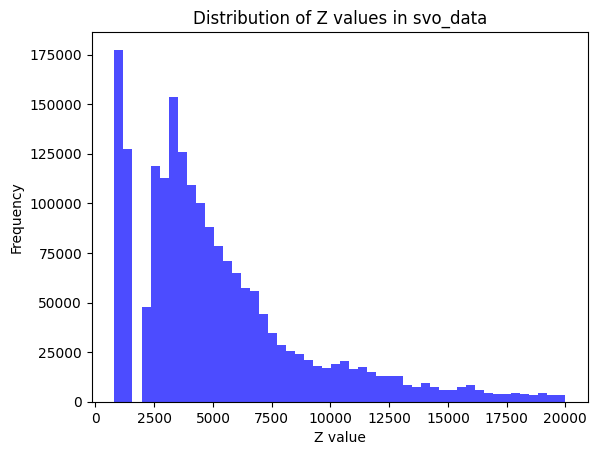

In [12]:
import matplotlib.pyplot as plt

# Extract the z values
z_values = v1['z']

# Create a histogram
plt.hist(z_values, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Z values in svo_data')
plt.xlabel('Z value')
plt.ylabel('Frequency')

plt.savefig('z_values_distribution.png')

# Show the plot
plt.show()

In [14]:
def export_colored_model(input_path, color, output_path): 
    input_pcl_path = Path("/home/skumar/benchmark_pixSFM/ply/sfm_in_camera_frame.ply")
    input_model = pycolmap.Reconstruction()
    input_model.import_PLY(input_pcl_path.as_posix())
    output_model = pycolmap.Reconstruction()
    custom_color = colors["yellow"]
    for id, point in input_model.points3D.items():
            output_model.add_point3D(xyz = point.xyz, track = pycolmap.Track(), color = custom_color)
    output_model.export_PLY("ply/sfm_yellow.ply")
    

#### SFM PCL TO CAMERA FRAME

In [ ]:
images = Path('pixsfm_dataset/')
outputs = Path('pixsfm_outputs/')
#!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'
raw_dir = outputs / "raw"
ref_dir_locked = outputs / "ref_locked"

In [ ]:
sfm_input_path = Path("dense_reconstruction/output/")

In [ ]:
os.listdir(sfm_input_path)

In [ ]:
sfm_model = pycolmap.Reconstruction()
sfm_model.read_binary(sfm_input_path.as_posix())

In [ ]:
sfm_model.summary()

In [ ]:
sys.path.append("/home/skumar/colmap/scripts/python")
from read_write_model import read_images_binary

In [ ]:
type(sfm_model.images)

In [ ]:
# for image_id, image in sfm_model.images.items():
#     print(f"{image_id} {image.name}")

In [ ]:
target_left_frame_id = 13
target_right_frame_id = 53
#print(f"{sfm_images_dict[target_left_frame_id].name} {sfm_images_dict[target_right_frame_id].name}")

In [ ]:
import numpy as np

fx = 1093.2768
fy = 1093.2768
cx = 964.989
cy = 569.276
#A = np.array([[fx,0 , cx], [0, fy, cy], [0 , 0, 1]]).astype(np.float64)

def get_camera_matrix(fx, fy, cx, cy):
    return np.array([[fx,0 , cx], [0, fy, cy], [0 , 0, 1]]).astype(np.float64)

def compute_cam_extrinsics(img):
    from read_write_model import qvec2rotmat
    R = qvec2rotmat(img.qvec)
    t = img.tvec.reshape(3,-1)
    R_t = np.concatenate((R,t), axis = 1)
    #R_t = np.vstack([np.array([0,0,0,1]), R_t])
    return R_t    # 3 * 4

def compute_projection_matrix(K, R_t):
    return np.dot(K, R_t)    


In [ ]:
left_img = sfm_model.images[13]
K = get_camera_matrix(fx,fy,cx,cy)
left_Rt = compute_cam_extrinsics(left_img)
P = compute_projection_matrix(K, left_Rt)

In [ ]:
print(f"{left_Rt}")

### Transfoming points to left camera frame

In [ ]:
from read_write_model import read_points3D_binary
sfm_points_path = sfm_input_path / "points3D.bin"
sfm_points_dict = read_points3D_binary(sfm_points_path)

In [ ]:
X = np.array([value.xyz for value in sfm_points_dict.values()])
ones = np.ones((X.shape[0], 1))
X_homo = np.hstack((X, ones)) #homogeneous co-ordinates

In [ ]:
X_homo.shape

In [ ]:
print(X_homo[0])

In [ ]:
left_Rt_homo = np.vstack((left_Rt, np.array([0, 0, 0, 1])))
print(f"left_Rt_homo: {left_Rt_homo}")

In [ ]:
X_lc_homo = np.dot(X_homo ,left_Rt_homo) #left camera frame 

In [ ]:
print(f"X_lc_homo.shape: {X_lc_homo.shape}")

In [ ]:
print(X_lc_homo[0])

In [ ]:
X_lc =  X_lc_homo[:, :3] / X_lc_homo[:, 3:] #dehomogenizing

In [ ]:
print(X_lc[0])

Updating the x,y,z values for the 3D points

In [ ]:
sfm_points_dict[12532]

In [ ]:
import copy
sfm_points_dict_ = copy.deepcopy(sfm_points_dict)

In [ ]:
type(X_lc[0,:])

In [ ]:
sfm_model_uncolored = pycolmap.Reconstruction()

In [ ]:
counter = 0
for id, pt in sfm_points_dict_.items():
    #point_3d = pycolmap.Point3D()
    #point_3d.xyz = pt.xyz
    #point_3d.color = pt.rgb
    sfm_model_uncolored.add_point3D(xyz = pt.xyz, track = pycolmap.Track(), color = pt.rgb)
    

In [ ]:
len(sfm_model_uncolored.points3D.values())

In [ ]:
sfm_model_uncolored.export_PLY("ply/sfm_uncolored.ply")

### Custom color for SFM model

In [ ]:
sfm_model_custom_colored = pycolmap.Reconstruction()

In [ ]:
for id, pt in sfm_points_dict_.items():
    #print(pt)
    sfm_model_custom_colored.add_point3D(xyz = pt.xyz, track = pycolmap.Track(), color = np.array([255,255,0]))
    #break

In [ ]:
sfm_model_custom_colored.export_PLY("ply/sfm_yellow.ply")

### Custom color for SVO model

In [ ]:
svo_input_path = Path("svo_output/frame_13/pointcloud/pointcloud.ply")
svo_model = pycolmap.Reconstruction()
svo_model.import_PLY(svo_input_path.as_posix())

In [ ]:
svo_model.summary()

In [ ]:
svo_points = svo_model.points3D

In [ ]:
a = list(svo_points.keys())

In [ ]:
a[1]

In [ ]:
svo_points[1929853].color

In [ ]:
colors = {
    "red": np.array([255, 0, 0]),
    "green": np.array([0, 255, 0]),
    "blue": np.array([0, 0, 255]),
    "yellow": np.array([255, 255, 0]),
    "cyan": np.array([0, 255, 255]),
    "magenta": np.array([255, 0, 255]),
    "white": np.array([255, 255, 255]),
    "black": np.array([0, 0, 0]),
    "orange": np.array([255, 165, 0]),
    "purple": np.array([128, 0, 128]),
    "brown": np.array([165, 42, 42]),
    "gray": np.array([128, 128, 128]),
    "pink": np.array([255, 192, 203]),
    "lime": np.array([0, 255, 0]),
    "indigo": np.array([75, 0, 130])
}

In [ ]:
svo_custom_color_model = pycolmap.Reconstruction()

In [ ]:
custom_color = colors["pink"]
for id, point in svo_model.points3D.items():
        svo_custom_color_model.add_point3D(xyz = point.xyz, track = pycolmap.Track(), color = custom_color)
    

In [ ]:
svo_custom_color_model.export_PLY("ply/svo_pink.ply")

In [ ]:
def colorize_pointcloud(input_pcl_path, color):
    input_pcl = pycolmap.Reconstruction()
    input_pcl.import_PLY(input_pcl_path.as_posix())
    input_pcl = copy.deepcopy(sfm_points_dict)